## Boxplot plots
_______
tg: @misha_grol and anna.petrovskaia@skoltech.ru


Boxplots for features based on DEM and NDVI

In [ ]:
# Uncomment for Google colab
# !pip install maxvolpy

# !pip install clhs

# !git clone https://github.com/EDSEL-skoltech/maxvol_sampling
    
# %cd maxvol_sampling/

In [3]:

import csv
import seaborn as sns


from scipy.spatial import distance
from scipy.stats import entropy
from scipy.special import kl_div
from scipy.stats import ks_2samp



import argparse
import numpy as np
import osgeo.gdal as gdal
import os

import pandas as pd
#by Anna
# from data_preparation import data_preparation
# from maxvol_cut import rect_maxvol_cut, f_no_cut, f_penal_2D
# from tools import norm_data, add_coords, gen_input, extend_score, points_selection, f_no_cut, f_cut_eps, calc_score, good_points_brute_force, idx_to_idx
import csv

import matplotlib.pyplot as plt

from src.util import MaxVolSampling

In [4]:
plt.rcParams["font.family"] = "Times New Roman"

plt.rcParams.update({'font.size': 16})
#use science style for plots
plt.style.use(['science', 'grid'])

plt.rcParams['xtick.labelsize'] =15

plt.rcParams['ytick.labelsize'] =20


## Interpolation plots

Parameter: Moisture_perc_10.npy


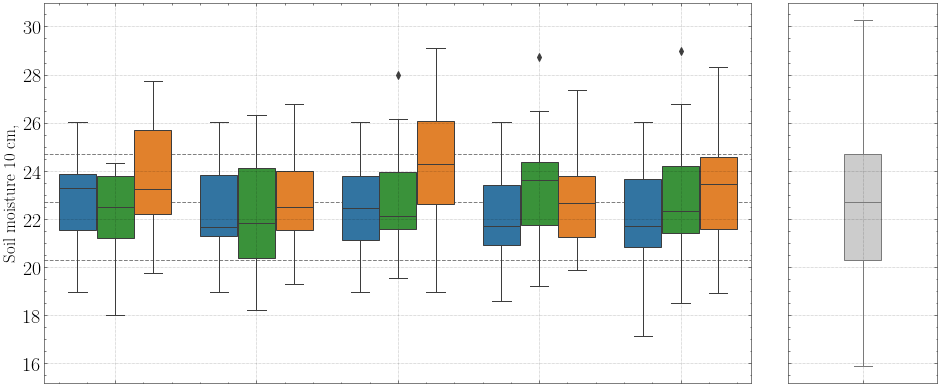

Parameter: Moisture_perc_30.npy


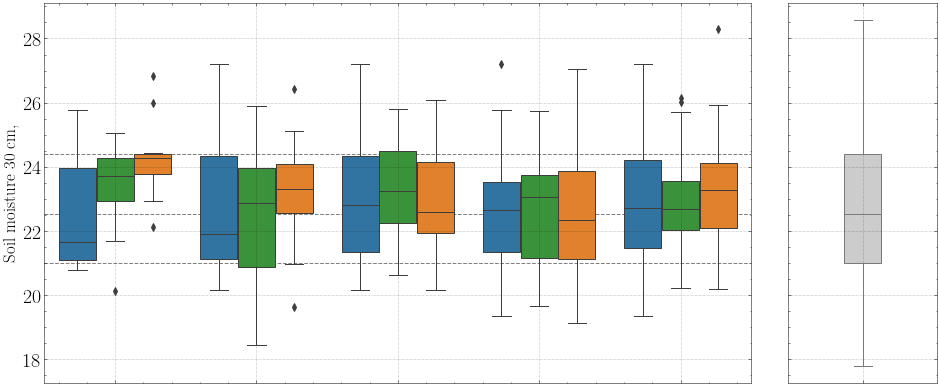

Parameter: Moisture_perc_80.npy


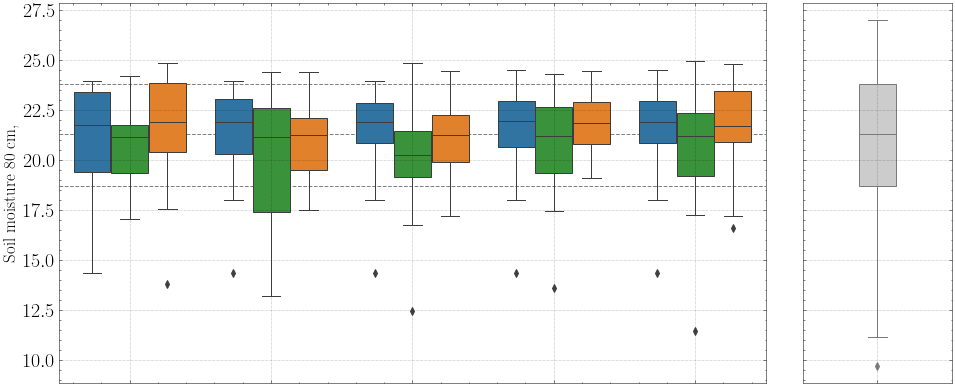

Parameter: mean_yeild_c_per_ha.npy


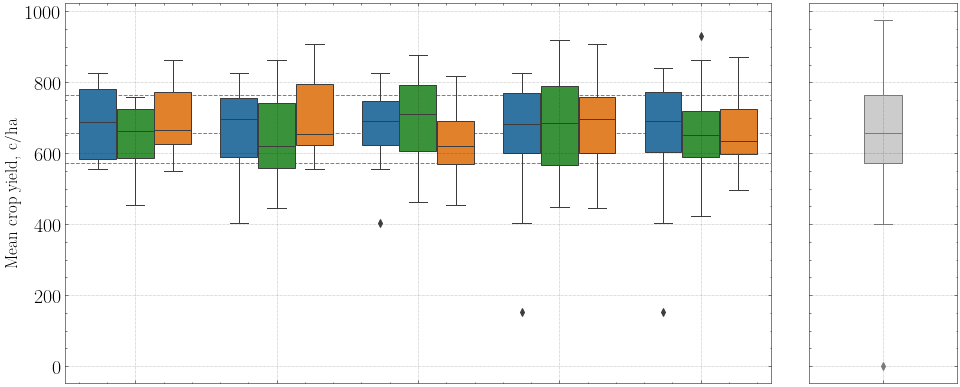

Parameter: pen_resist_10.npy


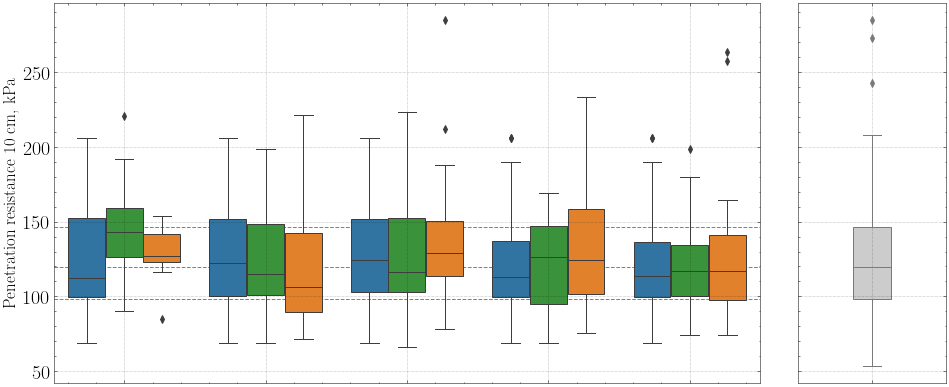

Parameter: pen_resist_30.npy


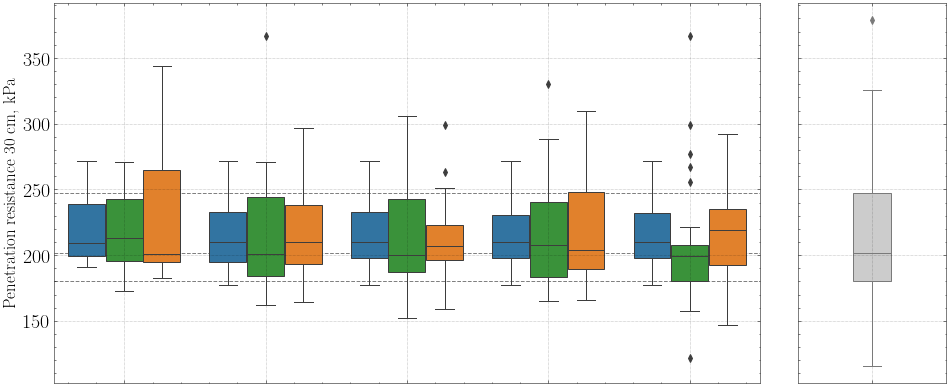

Parameter: pen_resist_80.npy


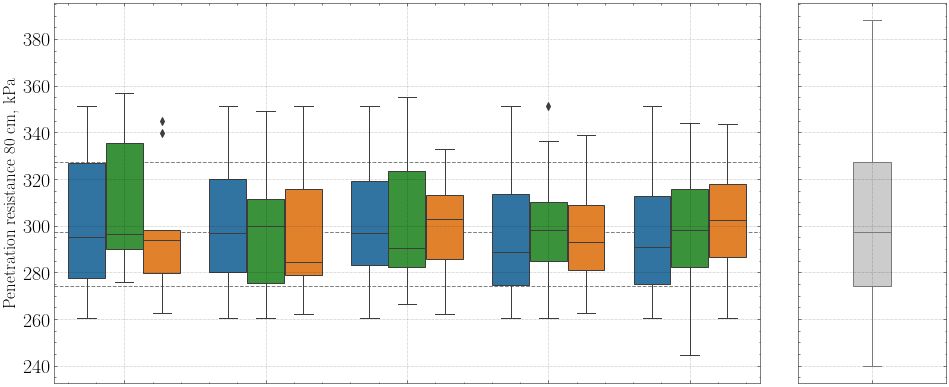

Parameter: temp_10.npy


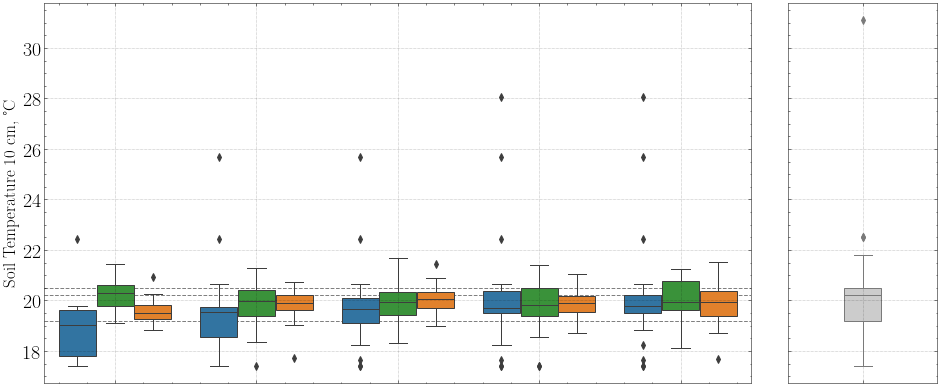

Parameter: temp_30.npy


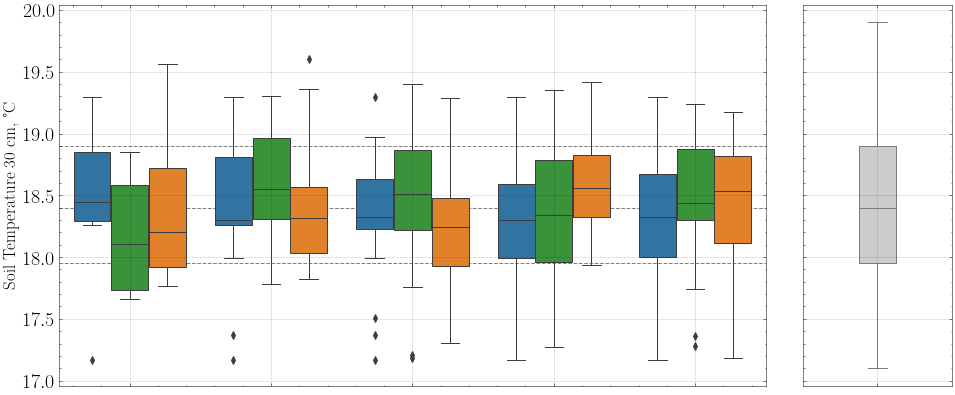

Parameter: temp_80.npy


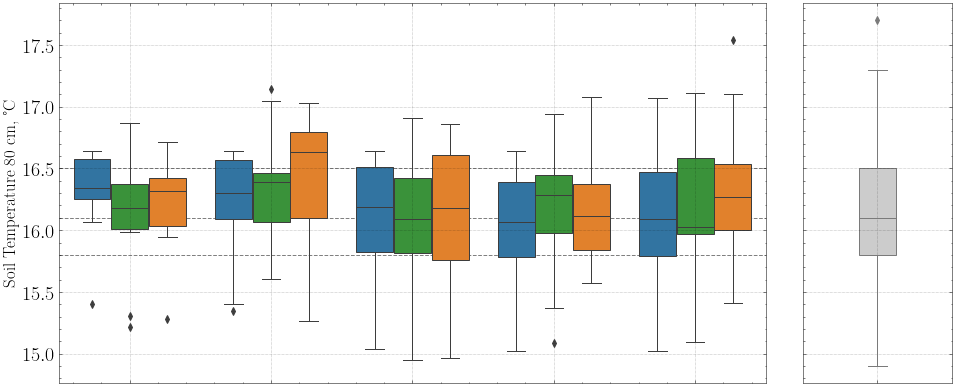

In [7]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tqdm.notebook import tqdm
from scipy.stats import ks_2samp


dict_for_dict_wasserstein = {}
csv_file_to_process = './src/data_v0.csv'
df_name = list(pd.read_csv(csv_file_to_process,  sep=',').columns)
soil_parameters = df_name
path_to_inter_npy_files = './experiments/cLHS_10_000/Interpolation_data/'

np.random.seed(42)
units = ['Soil moisture 10 cm, %','Soil moisture 30 cm, %','Soil moisture 80 cm, %','Mean crop yield, c/ha', 'Penetration resistance 10 cm, kPa','Penetration resistance 30 cm, kPa','Penetration resistance 80 cm, kPa', 'Soil Temperature 10 cm, °C','Soil Temperature 30 cm, °C','Soil Temperature 80 cm, °C']

interpolation_files = sorted(os.listdir('./experiments/cLHS_10_000/Interpolation_data/'))

path = './experiments/cLHS_million_steps'

for index, file in enumerate(interpolation_files):
    
    list_to_test_zeros = []
    print('Parameter:', file)

    df_for_plots = pd.DataFrame(columns=['Sampling', 'Points', 'Value'])


    dict_for_parameter = {'MAXVOL':{},
                         'cLHS':{}, 
                         'Random':{}}

    dict_for_wasserstein  = {'MAXVOL':{},
                         'cLHS':{}, 
                         'Random':{}}

    dict_for_plots  = {'MAXVOL':{},
                         'cLHS':{}, 
                         'Random':{}}

    number_of_points = [10,15,20,25,30]



    from itertools import compress
    list_of_cLHS_million_runs = sorted(os.listdir('./experiments/cLHS_million_steps'))
    selection = ['NDVI' in name for name in list_of_cLHS_million_runs] 
    cLHS_points_files = list(compress(list_of_cLHS_million_runs, selection))
    for num_points, csv_file in zip(number_of_points, cLHS_points_files):
        
        dict_for_parameter['cLHS'][num_points] = np.genfromtxt(os.path.join(path, csv_file),delimiter=',', dtype=int)
        SAR = MaxVolSampling()
        SAR.soil_feature = soil_parameters[index]
        SAR.num_of_points = num_points
        SAR.soil_data = pd.read_csv('./src/data_v0.csv',  sep=',')
        SAR.path_to_file_with_indices = None
        SAR.wd = './DEM_files/'
        
        SAR.path_to_interpolation_file = os.path.join(path_to_inter_npy_files, file)
        
        

        _  =SAR.data_preparation(SAR.wd, data_m=3, dem_dir = None)
        SAR.original_soil_data(SAR.soil_feature)

        #data from interpolation
        interpolation_map = SAR.interpolation_array
        #Points selection by MAXVOL
        MAXVOL = interpolation_map[SAR.i_am_maxvol_function()]
        
        print
        
        
        for value in MAXVOL:
            df_for_plots.loc[len(df_for_plots)]=['MAXVOL', num_points, value]        
        
        
        cLHS = interpolation_map[dict_for_parameter['cLHS'][num_points]]
        for value in cLHS:
            df_for_plots.loc[len(df_for_plots)]=['cLHS', num_points, value]
        

        

        RANDOM = interpolation_map[SAR.i_am_random()]

        for value in RANDOM:
            df_for_plots.loc[len(df_for_plots)]=['Random', num_points, value]


    #original distribution
    
    df_original = pd.DataFrame(data={'Points':[51]*len(SAR.original_data), 'Value':SAR.original_data})

    fig = plt.figure(figsize=(18,18))

    gs = gridspec.GridSpec(4, 5, wspace=.25)


    ax_1 = fig.add_subplot(gs[:,:4])
    ax_2 = fig.add_subplot(gs[:,4])

    sns.boxplot(ax = ax_1, x="Points", y="Value",
                hue="Sampling", palette=["#1F77B4", "#2CA02C", "#FF7F0E"],
                data=df_for_plots, width=0.8)

    sns.boxplot(ax = ax_2, x='Points', y="Value", palette=["#CCCCCC"],
                data=df_original, width=0.25)


    fig.set_figwidth(16)
    fig.set_figheight(7)

    ax_2.set_xticklabels([])
    ax_2.set_ylabel('')
    ax_2.set_xlabel('')
    ax_2.grid(True)
    
    ax_1.set_xticklabels([])
    ax_1.set_xlabel('')
    ax_1.set_ylabel(units[index], fontsize = 17)
    ax_1.axhline(np.quantile(SAR.original_data, 0.25), color='grey', linestyle='--',zorder=0)
    ax_1.axhline(np.quantile(SAR.original_data, 0.50), color='grey', linestyle='--',zorder=0)
    ax_1.axhline(np.quantile(SAR.original_data, 0.75), color='grey', linestyle='--',zorder=0)
    ax_1.get_shared_y_axes().join(ax_1, ax_2)
    ax_1.get_legend().remove()
    ax_1.grid(True)
    ax_2.set_yticklabels([])
#     plt.savefig('../plots/agricultural_systems_plots/boxplots_interpolation/'+str(soil_parameters[index])+'boxplot.svg')
#     plt.savefig('../plots/agricultural_systems_plots/boxplots_interpolation/'+str(soil_parameters[index])+'boxplot.png', dpi=300)
    plt.show()

#     break
